<a href="https://colab.research.google.com/github/tylerlum/ufc_automated_scoring_system/blob/main/UFC_Automated_Scoring_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UFC Automated Scoring System

The goal of this notebook is to:
* Explore the FightMetrics webpage to scrape the fight and fighter information we need
* Store the fight and fighter data into csv files
* Preprocess the data
* Train and evaluate a neural network to predict fight outcomes

Still functional as of April 2021

## Get information about all fighters

In [ ]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import re

In [ ]:
def get_all_fighters():
  '''Get pandas table of all UFC fighters (Name, Height, Weight, Reach, Record, etc.)'''
  from string import ascii_lowercase

  all_fighters_tables = []
  for c in tqdm(ascii_lowercase):
    all_fighters_url = f"http://ufcstats.com/statistics/fighters?char={c}&page=all"
    all_fighters_table = pd.read_html(all_fighters_url)[0]
    all_fighters_tables.append(all_fighters_table)

  all_fighters = pd.concat(all_fighters_tables)
  return all_fighters

In [ ]:
ALL_FIGHTERS = get_all_fighters()
ALL_FIGHTERS.head()

100%|██████████| 26/26 [00:17<00:00,  1.52it/s]


,First,Last,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,Belt
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tom,Aaron,NaN,--,155 lbs.,--,NaN,5.0,3.0,0.0,NaN
2,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,--,Orthodox,4.0,6.0,0.0,NaN
3,David,Abbott,Tank,"6' 0""",265 lbs.,--,Switch,10.0,15.0,0.0,NaN
4,Shamil,Abdurakhimov,Abrek,"6' 3""",235 lbs.,"76.0""",Orthodox,20.0,5.0,0.0,NaN


In [ ]:
ALL_FIGHTERS.dtypes

First        object
Last         object
Nickname     object
Ht.          object
Wt.          object
Reach        object
Stance       object
W           float64
L           float64
D           float64
Belt        float64
dtype: object

## Clean fighter data

TODO: Convert height, weight, reach to floats.

In [414]:
ALL_FIGHTERS = ALL_FIGHTERS.replace("^-+", np.nan, regex=True)  # Replace -- and --- with nan
ALL_FIGHTERS.head()

,First,Last,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,Belt
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tom,Aaron,NaN,NaN,155 lbs.,NaN,NaN,5.0,3.0,0.0,NaN
2,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,NaN,Orthodox,4.0,6.0,0.0,NaN
3,David,Abbott,Tank,"6' 0""",265 lbs.,NaN,Switch,10.0,15.0,0.0,NaN
4,Shamil,Abdurakhimov,Abrek,"6' 3""",235 lbs.,"76.0""",Orthodox,20.0,5.0,0.0,NaN


## Helper functions

In [ ]:
def get_fighters(fighters_string):
    '''Parses string containing two fighter names. Uses ALL_FIGHTERS global to remove ambiguity in parsing. Returns each fighter name
       Eg. "Robert Whittaker Kelvin Gastelum" => ("Robert Whittaker", "Kelvin Gastelum")'''
    for i, row in ALL_FIGHTERS.iterrows():
        fighter_name = f'{row["First"]} {row["Last"]}'
        if fighters_string.startswith(fighter_name):
            first_fighter = fighter_name
            second_fighter = fighters_string[len(fighter_name)+1:]
            break
    return first_fighter, second_fighter

def remove_duplicates_keep_order(list_):
    '''Removes duplicates while keeping same order'''
    return list(dict.fromkeys(list_))

## Get a list of all UFC events

In [ ]:
from urllib.request import urlopen
from string import ascii_uppercase
from dateutil import parser
from datetime import datetime

In [ ]:
ALL_PAST_EVENTS_URL = "http://ufcstats.com/statistics/events/completed?page=all"

In [ ]:
def get_all_events(all_past_events_url):
    '''Takes in URL to all past events. Returns list of urls, each one representing a UFC event'''
    all_past_events_html = urlopen(all_past_events_url).read().decode("utf-8")
    
    # Regex for "http://ufcstats.com/events-details/<alphanumeric>"
    # Eg. "http://ufcstats.com/event-details/27541033b97c076d"
    pattern = "\"http://ufcstats.com/event-details/[a-zA-Z0-9_]+\""
    all_urls = re.findall(pattern, all_past_events_html)

    # Remove quotes and duplicates
    all_urls = [url.strip("\"") for url in all_urls]
    all_urls = remove_duplicates_keep_order(all_urls)
    return all_urls

In [ ]:
# Events
ALL_EVENT_URLS = get_all_events(ALL_PAST_EVENTS_URL)
print(f"Got {len(ALL_EVENT_URLS)} events")
print()

print("Removing the most recent event, since it might not have happened yet")
ALL_EVENT_URLS = ALL_EVENT_URLS[1:]
print(f"Now got {len(ALL_EVENT_URLS)} events")
print(ALL_EVENT_URLS)

Got 559 events

Removing the most recent event, since it might not have happened yet
Now got 558 events
['http://ufcstats.com/event-details/4a35913bd9aa4161', 'http://ufcstats.com/event-details/9114c8ded5ccd71d', 'http://ufcstats.com/event-details/6597b611f1c32555', 'http://ufcstats.com/event-details/c36e1f4fa755ffb4', 'http://ufcstats.com/event-details/8c90c1563972e44d', 'http://ufcstats.com/event-details/6e2b1d631832921d', 'http://ufcstats.com/event-details/81b57acd6975ac06', 'http://ufcstats.com/event-details/bfe95ec546692b13', 'http://ufcstats.com/event-details/3f7c14c7eca7195d', 'http://ufcstats.com/event-details/a1153013cb5f628f', 'http://ufcstats.com/event-details/4304992c2acc187b', 'http://ufcstats.com/event-details/56116537d71a578c', 'http://ufcstats.com/event-details/307064d3e0f036c2', 'http://ufcstats.com/event-details/e49c2db95e572dc8', 'http://ufcstats.com/event-details/d0d43cb9b14f231c', 'http://ufcstats.com/event-details/398b440e73d55b8b', 'http://ufcstats.com/event-deta

## Get a list of UFC fights

TODO: Right now only sees if result is win. Else sets winner to None. See if this can be improved.

In [ ]:
def get_all_fights_in_event(past_event_url, get_results=False):
    '''Takes in a single URL to a past event.
       If get_results=True, returns fight_urls, winners, methods
       else, return fight_urls'''
    # Regex for "http://ufcstats.com/events-details/<alphanumeric>"
    # Eg. "http://ufcstats.com/fight-details/f67aa0b16e16a9ea"
    past_event_html = urlopen(past_event_url).read().decode("utf-8")
    pattern = "\"http://ufcstats.com/fight-details/[a-zA-Z0-9_]+\""
    fight_urls = re.findall(pattern, past_event_html)

    # Remove quotes and duplicates
    fight_urls = [url.strip("\"") for url in fight_urls]
    fight_urls = remove_duplicates_keep_order(fight_urls)

    # Get the winner and method (dec or KO or sub) of each fight
    past_event_table = pd.read_html(past_event_url)[0]  # Will be length 1 list
    winners, methods = [], []
    for _, row in past_event_table.iterrows():
        # TODO: Improve this processing of result
        result = row["W/L"].split(' ')[0]
        if result == "win":
            winner, _ = get_fighters(row["Fighter"])
        else:
            winner = None
        winners.append(winner)
        methods.append(row["Method"])

    if get_results:
        return fight_urls, winners, methods
    else:
        return fight_urls

In [ ]:
def get_all_fights(all_event_urls, num_events=None):
    '''Takes in list of URLs to past events. Returns 3 lists: urls, winners, methods, each representing a UFC fight.
       Set num_events to be the number of events to get fights from. Set to None if want all.'''
    if num_events is None:
        num_events = len(all_event_urls)
    
    all_fight_urls, all_winners, all_methods = [], [], []
    for i, event_url in enumerate(tqdm(all_event_urls[:num_events])):
        # For each event, get the fight urls and winners
        fight_urls, winners, methods = get_all_fights_in_event(event_url, get_results=True)
        all_fight_urls.extend(fight_urls)
        all_winners.extend(winners)
        all_methods.extend(methods)
    return all_fight_urls, all_winners, all_methods

In [ ]:
NUM_EVENTS = 3
FIGHT_URLS, WINNERS, METHODS = get_all_fights(ALL_EVENT_URLS, num_events=NUM_EVENTS)
print(f"Got {len(FIGHT_URLS)} fights")
print(FIGHT_URLS)
print(WINNERS)
print(METHODS)

assert(len(FIGHT_URLS) == len(WINNERS))
assert(len(FIGHT_URLS) == len(METHODS))

100%|██████████| 3/3 [00:08<00:00,  2.67s/it]

Got 33 fights
['http://ufcstats.com/fight-details/f67aa0b16e16a9ea', 'http://ufcstats.com/fight-details/f2c82f027201ba21', 'http://ufcstats.com/fight-details/a850ba762f3c5334', 'http://ufcstats.com/fight-details/0b2c3c4306620d6d', 'http://ufcstats.com/fight-details/a33ecd2c88154890', 'http://ufcstats.com/fight-details/fdfe4e7cb2d0b665', 'http://ufcstats.com/fight-details/25d4376e00b16510', 'http://ufcstats.com/fight-details/627c0a50cff30405', 'http://ufcstats.com/fight-details/8d634c9240f161dd', 'http://ufcstats.com/fight-details/24ff385ca78c80d3', 'http://ufcstats.com/fight-details/ddd63237f1b857a6', 'http://ufcstats.com/fight-details/71b81d8199a0fa19', 'http://ufcstats.com/fight-details/646eeca9447c6965', 'http://ufcstats.com/fight-details/0992795fd0fa06d0', 'http://ufcstats.com/fight-details/ac9a8b73e58f3d71', 'http://ufcstats.com/fight-details/e27c28928ed4390f', 'http://ufcstats.com/fight-details/998296216e7171ed', 'http://ufcstats.com/fight-details/7aebf01b5afc0109', 'http://ufcst

## Get fight tables


In [ ]:
def get_labeled_fight_tables(fight_url):
    '''Convert fight url to dictionary of pandas tables of information.
       Before, gave a list of tables that was hard to understand.
       Now have Totals, Per Round Totals, Significant Strikes, Per Round Significant Strikes'''
    fight_tables = pd.read_html(fight_url)
    
    labeled_fight_tables = {}
    labeled_fight_tables['Totals'] = fight_tables[0]
    labeled_fight_tables['Per Round Totals'] = fight_tables[1]
    labeled_fight_tables['Significant Strikes'] = fight_tables[2]
    labeled_fight_tables['Per Round Significant Strikes'] = fight_tables[3]
    return labeled_fight_tables

In [ ]:
RAW_FIGHT_TABLES_LIST = []
for url in tqdm(FIGHT_URLS):
    RAW_FIGHT_TABLES_LIST.append(get_labeled_fight_tables(url))

100%|██████████| 33/33 [00:09<00:00,  3.32it/s]


In [ ]:
RAW_FIGHT_TABLES_LIST[0]['Totals'].head()

,Fighter,KD,Sig. str.,Sig. str. %,Total str.,Td,Td %,Sub. att,Rev.,Ctrl
0,Robert Whittaker Kelvin Gastelum,0 0,150 of 284 62 of 209,52% 29%,169 of 303 70 of 218,4 of 7 1 of 5,57% 20%,0 0,0 0,4:19 0:26


In [ ]:
RAW_FIGHT_TABLES_LIST[0]['Per Round Totals'].head()

Fighter      KD  ...    Rev.        Ctrl
                            Round 1 Round 1  ... Round 1     Round 1
                            Round 2 Round 2  ... Round 2     Round 2
                            Round 3 Round 3  ... Round 3     Round 3
                            Round 4 Round 4  ... Round 4     Round 4
                            Round 5 Round 5  ... Round 5     Round 5
0  Robert Whittaker Kelvin Gastelum    0  0  ...    0  0  2:28  0:00
1  Robert Whittaker Kelvin Gastelum    0  0  ...    0  0  0:06  0:13
2  Robert Whittaker Kelvin Gastelum    0  0  ...    0  0  0:00  0:00
3  Robert Whittaker Kelvin Gastelum    0  0  ...    0  0  0:00  0:02
4  Robert Whittaker Kelvin Gastelum    0  0  ...    0  0  1:45  0:11

[5 rows x 10 columns]

In [ ]:
RAW_FIGHT_TABLES_LIST[0]['Significant Strikes'].head()

,Fighter,Sig. str,Sig. str. %,Head,Body,Leg,Distance,Clinch,Ground
0,Robert Whittaker Kelvin Gastelum,150 of 284 62 of 209,52% 29%,115 of 241 42 of 185,13 of 19 7 of 10,22 of 24 13 of 14,138 of 265 59 of 203,5 of 7 3 of 6,7 of 12 0 of 0


In [ ]:
RAW_FIGHT_TABLES_LIST[0]['Per Round Significant Strikes'].head()

,Fighter,Sig. str,Sig. str. %,Head,Body,Leg,Distance,Clinch,Ground,Unnamed: 9_level_0
,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1
,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2
,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3
,Round 4,Round 4,Round 4,Round 4,Round 4,Round 4,Round 4,Round 4,Round 4,Round 4
,Round 5,Round 5,Round 5,Round 5,Round 5,Round 5,Round 5,Round 5,Round 5,Round 5
0,Robert Whittaker Kelvin Gastelum,18 of 42 8 of 19,42% 42%,16 of 38 3 of 13,0 of 1 1 of 2,2 of 3 4 of 4,14 of 34 8 of 19,0 of 0 0 of 0,4 of 8 0 of 0,NaN
1,Robert Whittaker Kelvin Gastelum,43 of 74 14 of 61,58% 22%,33 of 61 9 of 56,5 of 8 1 of 1,5 of 5 4 of 4,39 of 69 14 of 61,2 of 2 0 of 0,2 of 3 0 of 0,NaN
2,Robert Whittaker Kelvin Gastelum,38 of 64 20 of 57,59% 35%,27 of 53 12 of 47,6 of 6 3 of 4,5 of 5 5 of 6,36 of 61 20 of 55,2 of 3 0 of 2,0 of 0 0 of 0,NaN
3,Robert Whittaker Kelvin Gastelum,33 of 71 13 of 43,46% 30%,25 of 61 12 of 41,2 of 3 1 of 2,6 of 7 0 of 0,32 of 69 10 of 39,1 of 2 3 of 4,0 of 0 0 of 0,NaN
4,Robert Whittaker Kelvin Gastelum,18 of 33 7 of 29,54% 24%,14 of 28 6 of 28,0 of 1 1 of 1,4 of 4 0 of 0,17 of 32 7 of 29,0 of 0 0 of 0,1 of 1 0 of 0,NaN


## Clean fight information

Separate each fighter's information into a different column

TODO: Lots of stuff to improve. Smarter use of Totals, round by round, and significant strikes. Can also use non integer information, total attempted strikes (not just landed), fighter information, etc. All of those being ignored right now. Find nice way to parse new information round by round. Handle no winner case better. May need to add ignore_index=True for pd.concat

In [395]:
def parse_string(row_string):
    '''Break string into two parts: one for fighter 0 and one for fighter 1
       Eg. 150 of 284  62 of 209 => (150 of 284, 62 of 209)'''
    if not isinstance(row_string, str):
        print(f"row_string = {row_string} is not a string")
        return "0", "0"
    string_split = row_string.split(" ")
    first_fighter_stat = " ".join(string_split[:len(string_split)//2])
    second_fighter_stat = " ".join(string_split[len(string_split)//2+1:])
    return first_fighter_stat, second_fighter_stat

In [396]:
def convert_to_int_or_double_if_possible(string):
    '''Convert string to int or double if possible
       If has a percent sign, tries to remove it and continue.'''
    def isfloat(value):
        try:
            float(value)
            return True
        except ValueError:
            return False

    # If input is not string, then return it unchanged
    if not isinstance(string, str):
        return string

    # Remove %
    if "%" in string:
        string = string.strip("%")

    # Convert to int or float
    if isfloat(string) and float(string).is_integer():
        return int(string)
    if isfloat(string):
        return float(string)
    return string

In [397]:
def process_fight(raw_fight_table):
    '''Takes in a raw, one-row pandas fight table. Returns a pandas dataframe representing the fight statistics'''    
    # Break up columns.
    # Eg. "Name" => "Fighter 0 Name", "Fighter 1 Name"
    # "KD" => "Fighter 0 KD", "Fighter 1 KD"
    new_columns = []
    for column in raw_fight_table.columns:
        new_columns.append(f"Fighter 0 {column}")
        new_columns.append(f"Fighter 1 {column}")

    # Go through each row and break up the data into the columns
    new_rows = []
    for i, row in raw_fight_table.iterrows():
        new_row = []
        for column in raw_fight_table.columns:
            # Split string at the center space
            stat1, stat2 = parse_string(row[column])

            # TODO: Update this to capture more information

            # Has "100 of 120" type stat. Just store first number
            if "of" in stat1:
                stat1 = stat1.split(" of ")[0]
                stat2 = stat2.split(" of ")[0]

            # Has "2:32" type stat (min:sec). Convert to sec.
            elif ":" in stat1:
                min1, sec1 = stat1.split(":")[0], stat1.split(":")[1]
                min2, sec2 = stat2.split(":")[0], stat2.split(":")[1]
                stat1 = convert_to_int_or_double_if_possible(min1)*60 + convert_to_int_or_double_if_possible(sec1)
                stat2 = convert_to_int_or_double_if_possible(min2)*60 + convert_to_int_or_double_if_possible(sec2)
            
            # Convert string to float or int if possible
            stat1 = convert_to_int_or_double_if_possible(stat1)
            stat2 = convert_to_int_or_double_if_possible(stat2)

            # Add to row
            new_row.append(stat1)
            new_row.append(stat2)
        new_rows.append(new_row)

    # Bring together into new dataframe, then only store the numerical values
    # TODO: Process better to keep more info, not throw so much away
    df = pd.DataFrame(new_rows, columns=new_columns)

    # Add in names, using smarter parsing
    df = df.drop(columns=['Fighter 0 Fighter', 'Fighter 1 Fighter'])
    fighters_string = raw_fight_table["Fighter"][0]  # Only 1 row table
    fighter0, fighter1 = get_fighters(fighters_string)
    df['Fighter 0 Name'] = fighter0
    df['Fighter 1 Name'] = fighter1
    return df

In [430]:
def process_raw_fight_tables(raw_fight_tables, winner, method, round_by_round=False):
    '''Takes in set of raw fight table (one fight), the name of the fight winner, and the method of winning. Returns a cleaned pandas table.
       Set round_by_round=True to use the round-by-round data. Otherwise, uses full fight stats.'''
    def create_aggregated_fight_table(raw_fight_tables):
        # Aggregate data from multiple tables
        fight_table = process_fight(raw_fight_tables["Totals"])
        fight_table2 = process_fight(raw_fight_tables["Significant Strikes"])
        
        # Rename column names with identical data to match
        fight_table2 = fight_table2.rename(columns={"Fighter 0 Sig. str": "Fighter 0 Sig. str.", "Fighter 1 Sig. str": "Fighter 1 Sig. str."})

        # Bring tables together, then remove duplicates
        fight_table = pd.concat([fight_table, fight_table2], axis=1)
        fight_table = fight_table.loc[:,~fight_table.columns.duplicated()]
        return fight_table

    def create_aggregated_round_by_round_fight_table(raw_fight_tables):
        ##### Aggregate data totals table
        tables = []
        for i, row in raw_fight_tables["Per Round Totals"].iterrows():
            # Get df of one round
            df = pd.DataFrame(row)
            values = list(df[i].to_dict().values())
            cols = list(raw_fight_tables["Totals"].columns)
            df = pd.DataFrame([values], columns=cols)

            # Update columns with round number
            new_cols = [f"Round {i+1} {c}" if c != "Fighter" else c for c in cols]
            df.columns = new_cols
            tables.append(process_fight(df))
        # Concatenate round-by-round horizontally, so each row is for 1 fight.
        # Then remove duplicates
        totals_df = pd.concat(tables, axis=1)
        totals_df = totals_df.loc[:,~totals_df.columns.duplicated()]

        ##### Aggregate data significant strikes table
        tables = []
        for i, row in raw_fight_tables["Per Round Significant Strikes"].iterrows():
            # Get df of one round
            df = pd.DataFrame(row)
            values = list(df[i].to_dict().values())
            cols = list(raw_fight_tables["Significant Strikes"].columns)
            if len(values) != len(cols):
                values = values[:-1]  # Remove last column values, as shown above, has extra column for no reason
            df = pd.DataFrame([values], columns=cols)

            # Update columns with round number
            new_cols = [f"Round {i+1} {c}" if c != "Fighter" else c for c in cols]
            df.columns = new_cols
            tables.append(process_fight(df))
        # Concatenate round-by-round horizontally, so each row is for 1 fight
        # Then remove duplicates
        sig_strikes_df = pd.concat(tables, axis=1)
        sig_strikes_df = sig_strikes_df.loc[:,~sig_strikes_df.columns.duplicated()]
        
        ##### Bring tables together, then remove duplicates
        fight_table = pd.concat([totals_df, sig_strikes_df], axis=1)
        fight_table = fight_table.loc[:,~fight_table.columns.duplicated()]
        return fight_table


    if round_by_round:
        fight_table = create_aggregated_round_by_round_fight_table(raw_fight_tables)
    else:
        fight_table = create_aggregated_fight_table(raw_fight_tables)

    if fight_table["Fighter 0 Name"][0] == winner:
        label = 0
    elif fight_table["Fighter 1 Name"][0] == winner:
        label = 1
    else:
        print(f'ERROR: fight_table["Fighter 0 Name"]={fight_table["Fighter 0 Name"]}, fight_table["Fighter 1 Name"]={fight_table["Fighter 1 Name"]}, winner={winner}')
        label = -1
    fight_table['Winner'] = label
    fight_table['Method'] = method
    return fight_table

In [432]:
ROUND_BY_ROUND = True
FIGHT_TABLE = []
for i in tqdm(range(len(RAW_FIGHT_TABLES_LIST))):
    FIGHT_TABLE.append(process_raw_fight_tables(RAW_FIGHT_TABLES_LIST[i], WINNERS[i], METHODS[i], round_by_round=ROUND_BY_ROUND)) 
FIGHT_TABLE = pd.concat(FIGHT_TABLE, ignore_index=True)
FIGHT_TABLE = FIGHT_TABLE.replace("^-+", np.nan, regex=True)  # Replace -- and --- with nan















  0%|          | 0/2 [00:00<?, ?it/s]













 50%|█████     | 1/2 [00:04<00:04,  4.34s/it]













100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


In [433]:
FIGHT_TABLE.head()

,Fighter 0 Round 1 KD,Fighter 1 Round 1 KD,Fighter 0 Round 1 Sig. str.,Fighter 1 Round 1 Sig. str.,Fighter 0 Round 1 Sig. str. %,Fighter 1 Round 1 Sig. str. %,Fighter 0 Round 1 Total str.,Fighter 1 Round 1 Total str.,Fighter 0 Round 1 Td,Fighter 1 Round 1 Td,Fighter 0 Round 1 Td %,Fighter 1 Round 1 Td %,Fighter 0 Round 1 Sub. att,Fighter 1 Round 1 Sub. att,Fighter 0 Round 1 Rev.,Fighter 1 Round 1 Rev.,Fighter 0 Round 1 Ctrl,Fighter 1 Round 1 Ctrl,Fighter 0 Name,Fighter 1 Name,Fighter 0 Round 2 KD,Fighter 1 Round 2 KD,Fighter 0 Round 2 Sig. str.,Fighter 1 Round 2 Sig. str.,Fighter 0 Round 2 Sig. str. %,Fighter 1 Round 2 Sig. str. %,Fighter 0 Round 2 Total str.,Fighter 1 Round 2 Total str.,Fighter 0 Round 2 Td,Fighter 1 Round 2 Td,Fighter 0 Round 2 Td %,Fighter 1 Round 2 Td %,Fighter 0 Round 2 Sub. att,Fighter 1 Round 2 Sub. att,Fighter 0 Round 2 Rev.,Fighter 1 Round 2 Rev.,Fighter 0 Round 2 Ctrl,Fighter 1 Round 2 Ctrl,Fighter 0 Round 3 KD,Fighter 1 Round 3 KD,...,Fighter 0 Round 3 Body,Fighter 1 Round 3 Body,Fighter 0 Round 3 Leg,Fighter 1 Round 3 Leg,Fighter 0 Round 3 Distance,Fighter 1 Round 3 Distance,Fighter 0 Round 3 Clinch,Fighter 1 Round 3 Clinch,Fighter 0 Round 3 Ground,Fighter 1 Round 3 Ground,Fighter 0 Round 4 Sig. str,Fighter 1 Round 4 Sig. str,Fighter 0 Round 4 Head,Fighter 1 Round 4 Head,Fighter 0 Round 4 Body,Fighter 1 Round 4 Body,Fighter 0 Round 4 Leg,Fighter 1 Round 4 Leg,Fighter 0 Round 4 Distance,Fighter 1 Round 4 Distance,Fighter 0 Round 4 Clinch,Fighter 1 Round 4 Clinch,Fighter 0 Round 4 Ground,Fighter 1 Round 4 Ground,Fighter 0 Round 5 Sig. str,Fighter 1 Round 5 Sig. str,Fighter 0 Round 5 Head,Fighter 1 Round 5 Head,Fighter 0 Round 5 Body,Fighter 1 Round 5 Body,Fighter 0 Round 5 Leg,Fighter 1 Round 5 Leg,Fighter 0 Round 5 Distance,Fighter 1 Round 5 Distance,Fighter 0 Round 5 Clinch,Fighter 1 Round 5 Clinch,Fighter 0 Round 5 Ground,Fighter 1 Round 5 Ground,Winner,Method
0,0,0,18,8,42,42,33,8,1,0,100.0,NaN,0,0,0,0,148,0,Robert Whittaker,Kelvin Gastelum,0,0,43,14,58,22,44,16,1,0,100.0,0.0,0,0,0,0,6,13,0,0,...,6,3,5,5,36,20,2,0,0,0,33.0,13.0,25.0,12.0,2.0,1.0,6.0,0.0,32.0,10.0,1.0,3.0,0.0,0.0,18.0,7.0,14.0,6.0,0.0,1.0,4.0,0.0,17.0,7.0,0.0,0.0,1.0,0.0,0,U-DEC
1,0,0,27,33,41,47,27,33,0,0,NaN,NaN,0,0,0,0,0,0,Andrei Arlovski,Chase Sherman,0,0,32,21,46,36,36,32,0,0,NaN,NaN,0,0,0,0,39,0,0,0,...,12,6,11,7,46,33,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,U-DEC


In [440]:
FIGHT_TABLE.tail()

,Fighter 0 Round 1 KD,Fighter 1 Round 1 KD,Fighter 0 Round 1 Sig. str.,Fighter 1 Round 1 Sig. str.,Fighter 0 Round 1 Sig. str. %,Fighter 1 Round 1 Sig. str. %,Fighter 0 Round 1 Total str.,Fighter 1 Round 1 Total str.,Fighter 0 Round 1 Td,Fighter 1 Round 1 Td,Fighter 0 Round 1 Td %,Fighter 1 Round 1 Td %,Fighter 0 Round 1 Sub. att,Fighter 1 Round 1 Sub. att,Fighter 0 Round 1 Rev.,Fighter 1 Round 1 Rev.,Fighter 0 Round 1 Ctrl,Fighter 1 Round 1 Ctrl,Fighter 0 Name,Fighter 1 Name,Fighter 0 Round 2 KD,Fighter 1 Round 2 KD,Fighter 0 Round 2 Sig. str.,Fighter 1 Round 2 Sig. str.,Fighter 0 Round 2 Sig. str. %,Fighter 1 Round 2 Sig. str. %,Fighter 0 Round 2 Total str.,Fighter 1 Round 2 Total str.,Fighter 0 Round 2 Td,Fighter 1 Round 2 Td,Fighter 0 Round 2 Td %,Fighter 1 Round 2 Td %,Fighter 0 Round 2 Sub. att,Fighter 1 Round 2 Sub. att,Fighter 0 Round 2 Rev.,Fighter 1 Round 2 Rev.,Fighter 0 Round 2 Ctrl,Fighter 1 Round 2 Ctrl,Fighter 0 Round 3 KD,Fighter 1 Round 3 KD,...,Fighter 0 Round 3 Body,Fighter 1 Round 3 Body,Fighter 0 Round 3 Leg,Fighter 1 Round 3 Leg,Fighter 0 Round 3 Distance,Fighter 1 Round 3 Distance,Fighter 0 Round 3 Clinch,Fighter 1 Round 3 Clinch,Fighter 0 Round 3 Ground,Fighter 1 Round 3 Ground,Fighter 0 Round 4 Sig. str,Fighter 1 Round 4 Sig. str,Fighter 0 Round 4 Head,Fighter 1 Round 4 Head,Fighter 0 Round 4 Body,Fighter 1 Round 4 Body,Fighter 0 Round 4 Leg,Fighter 1 Round 4 Leg,Fighter 0 Round 4 Distance,Fighter 1 Round 4 Distance,Fighter 0 Round 4 Clinch,Fighter 1 Round 4 Clinch,Fighter 0 Round 4 Ground,Fighter 1 Round 4 Ground,Fighter 0 Round 5 Sig. str,Fighter 1 Round 5 Sig. str,Fighter 0 Round 5 Head,Fighter 1 Round 5 Head,Fighter 0 Round 5 Body,Fighter 1 Round 5 Body,Fighter 0 Round 5 Leg,Fighter 1 Round 5 Leg,Fighter 0 Round 5 Distance,Fighter 1 Round 5 Distance,Fighter 0 Round 5 Clinch,Fighter 1 Round 5 Clinch,Fighter 0 Round 5 Ground,Fighter 1 Round 5 Ground,Winner,Method
0,0,0,18,8,42,42,33,8,1,0,100.0,NaN,0,0,0,0,148,0,Robert Whittaker,Kelvin Gastelum,0,0,43,14,58,22,44,16,1,0,100.0,0.0,0,0,0,0,6,13,0,0,...,6,3,5,5,36,20,2,0,0,0,33.0,13.0,25.0,12.0,2.0,1.0,6.0,0.0,32.0,10.0,1.0,3.0,0.0,0.0,18.0,7.0,14.0,6.0,0.0,1.0,4.0,0.0,17.0,7.0,0.0,0.0,1.0,0.0,0,U-DEC
1,0,0,27,33,41,47,27,33,0,0,NaN,NaN,0,0,0,0,0,0,Andrei Arlovski,Chase Sherman,0,0,32,21,46,36,36,32,0,0,NaN,NaN,0,0,0,0,39,0,0,0,...,12,6,11,7,46,33,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,U-DEC


## Augment dataset by flipping around columns

The system should work the same no matter what order we pass in the fighters. Let fighters be A and B. We want

winner(fighter0=A, fighter1=B) = winner(fighter0=B, fighter1=A)

In [441]:
def create_flipped_table(table):
    '''Rearranges columns of table so that each fight has two rows. Let fighters be A and B.
       One row has (Fighter 0 = A, Fighter 1 = B). One row has (Fighter 0 = B, Fighter 1 = A)
       Ensure same column order, as column names not looked at when passed to ML model'''

    # Get columns in flipped order, which moves the columns around, but changes column name order too
    flipped_columns = []
    for column in table.columns:
        if "Fighter 0" in column:
          flipped_columns.append(column.replace("Fighter 0", "Fighter 1"))
        elif "Fighter 1" in column:
          flipped_columns.append(column.replace("Fighter 1", "Fighter 0"))
        else:
          flipped_columns.append(column)
    flipped_table = table[flipped_columns]

    # Flips winners around
    if 'Winner' in flipped_table.columns:
       flipped_table['Winner'] = flipped_table['Winner'].replace([0, 1], [1, 0])

    # Change column names back to normal
    flipped_table.columns = table.columns
    return flipped_table

In [442]:
def add_rows_of_flipped_columns(table):
    flipped_table = create_flipped_table(table)
    new_table = pd.concat([table, flipped_table])
    return new_table

In [443]:
FULL_FIGHT_TABLE = add_rows_of_flipped_columns(FIGHT_TABLE)

In [444]:
FULL_FIGHT_TABLE.head()

,Fighter 0 Round 1 KD,Fighter 1 Round 1 KD,Fighter 0 Round 1 Sig. str.,Fighter 1 Round 1 Sig. str.,Fighter 0 Round 1 Sig. str. %,Fighter 1 Round 1 Sig. str. %,Fighter 0 Round 1 Total str.,Fighter 1 Round 1 Total str.,Fighter 0 Round 1 Td,Fighter 1 Round 1 Td,Fighter 0 Round 1 Td %,Fighter 1 Round 1 Td %,Fighter 0 Round 1 Sub. att,Fighter 1 Round 1 Sub. att,Fighter 0 Round 1 Rev.,Fighter 1 Round 1 Rev.,Fighter 0 Round 1 Ctrl,Fighter 1 Round 1 Ctrl,Fighter 0 Name,Fighter 1 Name,Fighter 0 Round 2 KD,Fighter 1 Round 2 KD,Fighter 0 Round 2 Sig. str.,Fighter 1 Round 2 Sig. str.,Fighter 0 Round 2 Sig. str. %,Fighter 1 Round 2 Sig. str. %,Fighter 0 Round 2 Total str.,Fighter 1 Round 2 Total str.,Fighter 0 Round 2 Td,Fighter 1 Round 2 Td,Fighter 0 Round 2 Td %,Fighter 1 Round 2 Td %,Fighter 0 Round 2 Sub. att,Fighter 1 Round 2 Sub. att,Fighter 0 Round 2 Rev.,Fighter 1 Round 2 Rev.,Fighter 0 Round 2 Ctrl,Fighter 1 Round 2 Ctrl,Fighter 0 Round 3 KD,Fighter 1 Round 3 KD,...,Fighter 0 Round 3 Body,Fighter 1 Round 3 Body,Fighter 0 Round 3 Leg,Fighter 1 Round 3 Leg,Fighter 0 Round 3 Distance,Fighter 1 Round 3 Distance,Fighter 0 Round 3 Clinch,Fighter 1 Round 3 Clinch,Fighter 0 Round 3 Ground,Fighter 1 Round 3 Ground,Fighter 0 Round 4 Sig. str,Fighter 1 Round 4 Sig. str,Fighter 0 Round 4 Head,Fighter 1 Round 4 Head,Fighter 0 Round 4 Body,Fighter 1 Round 4 Body,Fighter 0 Round 4 Leg,Fighter 1 Round 4 Leg,Fighter 0 Round 4 Distance,Fighter 1 Round 4 Distance,Fighter 0 Round 4 Clinch,Fighter 1 Round 4 Clinch,Fighter 0 Round 4 Ground,Fighter 1 Round 4 Ground,Fighter 0 Round 5 Sig. str,Fighter 1 Round 5 Sig. str,Fighter 0 Round 5 Head,Fighter 1 Round 5 Head,Fighter 0 Round 5 Body,Fighter 1 Round 5 Body,Fighter 0 Round 5 Leg,Fighter 1 Round 5 Leg,Fighter 0 Round 5 Distance,Fighter 1 Round 5 Distance,Fighter 0 Round 5 Clinch,Fighter 1 Round 5 Clinch,Fighter 0 Round 5 Ground,Fighter 1 Round 5 Ground,Winner,Method
0,0,0,18,8,42,42,33,8,1,0,100.0,NaN,0,0,0,0,148,0,Robert Whittaker,Kelvin Gastelum,0,0,43,14,58,22,44,16,1,0,100.0,0.0,0,0,0,0,6,13,0,0,...,6,3,5,5,36,20,2,0,0,0,33.0,13.0,25.0,12.0,2.0,1.0,6.0,0.0,32.0,10.0,1.0,3.0,0.0,0.0,18.0,7.0,14.0,6.0,0.0,1.0,4.0,0.0,17.0,7.0,0.0,0.0,1.0,0.0,0,U-DEC
1,0,0,27,33,41,47,27,33,0,0,NaN,NaN,0,0,0,0,0,0,Andrei Arlovski,Chase Sherman,0,0,32,21,46,36,36,32,0,0,NaN,NaN,0,0,0,0,39,0,0,0,...,12,6,11,7,46,33,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,U-DEC
0,0,0,8,18,42,42,8,33,0,1,NaN,100.0,0,0,0,0,0,148,Kelvin Gastelum,Robert Whittaker,0,0,14,43,22,58,16,44,0,1,0.0,100.0,0,0,0,0,13,6,0,0,...,3,6,5,5,20,36,0,2,0,0,13.0,33.0,12.0,25.0,1.0,2.0,0.0,6.0,10.0,32.0,3.0,1.0,0.0,0.0,7.0,18.0,6.0,14.0,1.0,0.0,0.0,4.0,7.0,17.0,0.0,0.0,0.0,1.0,1,U-DEC
1,0,0,33,27,47,41,33,27,0,0,NaN,NaN,0,0,0,0,0,0,Chase Sherman,Andrei Arlovski,0,0,21,32,36,46,32,36,0,0,NaN,NaN,0,0,0,0,0,39,0,0,...,6,12,7,11,33,46,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,U-DEC


## Example of augmented data

In [445]:
FULL_FIGHT_TABLE[(FULL_FIGHT_TABLE['Fighter 0 Name'] == "Robert Whittaker") & (FULL_FIGHT_TABLE['Fighter 1 Name'] == "Kelvin Gastelum")]

,Fighter 0 Round 1 KD,Fighter 1 Round 1 KD,Fighter 0 Round 1 Sig. str.,Fighter 1 Round 1 Sig. str.,Fighter 0 Round 1 Sig. str. %,Fighter 1 Round 1 Sig. str. %,Fighter 0 Round 1 Total str.,Fighter 1 Round 1 Total str.,Fighter 0 Round 1 Td,Fighter 1 Round 1 Td,Fighter 0 Round 1 Td %,Fighter 1 Round 1 Td %,Fighter 0 Round 1 Sub. att,Fighter 1 Round 1 Sub. att,Fighter 0 Round 1 Rev.,Fighter 1 Round 1 Rev.,Fighter 0 Round 1 Ctrl,Fighter 1 Round 1 Ctrl,Fighter 0 Name,Fighter 1 Name,Fighter 0 Round 2 KD,Fighter 1 Round 2 KD,Fighter 0 Round 2 Sig. str.,Fighter 1 Round 2 Sig. str.,Fighter 0 Round 2 Sig. str. %,Fighter 1 Round 2 Sig. str. %,Fighter 0 Round 2 Total str.,Fighter 1 Round 2 Total str.,Fighter 0 Round 2 Td,Fighter 1 Round 2 Td,Fighter 0 Round 2 Td %,Fighter 1 Round 2 Td %,Fighter 0 Round 2 Sub. att,Fighter 1 Round 2 Sub. att,Fighter 0 Round 2 Rev.,Fighter 1 Round 2 Rev.,Fighter 0 Round 2 Ctrl,Fighter 1 Round 2 Ctrl,Fighter 0 Round 3 KD,Fighter 1 Round 3 KD,...,Fighter 0 Round 3 Body,Fighter 1 Round 3 Body,Fighter 0 Round 3 Leg,Fighter 1 Round 3 Leg,Fighter 0 Round 3 Distance,Fighter 1 Round 3 Distance,Fighter 0 Round 3 Clinch,Fighter 1 Round 3 Clinch,Fighter 0 Round 3 Ground,Fighter 1 Round 3 Ground,Fighter 0 Round 4 Sig. str,Fighter 1 Round 4 Sig. str,Fighter 0 Round 4 Head,Fighter 1 Round 4 Head,Fighter 0 Round 4 Body,Fighter 1 Round 4 Body,Fighter 0 Round 4 Leg,Fighter 1 Round 4 Leg,Fighter 0 Round 4 Distance,Fighter 1 Round 4 Distance,Fighter 0 Round 4 Clinch,Fighter 1 Round 4 Clinch,Fighter 0 Round 4 Ground,Fighter 1 Round 4 Ground,Fighter 0 Round 5 Sig. str,Fighter 1 Round 5 Sig. str,Fighter 0 Round 5 Head,Fighter 1 Round 5 Head,Fighter 0 Round 5 Body,Fighter 1 Round 5 Body,Fighter 0 Round 5 Leg,Fighter 1 Round 5 Leg,Fighter 0 Round 5 Distance,Fighter 1 Round 5 Distance,Fighter 0 Round 5 Clinch,Fighter 1 Round 5 Clinch,Fighter 0 Round 5 Ground,Fighter 1 Round 5 Ground,Winner,Method
0,0,0,18,8,42,42,33,8,1,0,100.0,NaN,0,0,0,0,148,0,Robert Whittaker,Kelvin Gastelum,0,0,43,14,58,22,44,16,1,0,100.0,0.0,0,0,0,0,6,13,0,0,...,6,3,5,5,36,20,2,0,0,0,33.0,13.0,25.0,12.0,2.0,1.0,6.0,0.0,32.0,10.0,1.0,3.0,0.0,0.0,18.0,7.0,14.0,6.0,0.0,1.0,4.0,0.0,17.0,7.0,0.0,0.0,1.0,0.0,0,U-DEC


In [446]:
FULL_FIGHT_TABLE[(FULL_FIGHT_TABLE['Fighter 1 Name'] == "Robert Whittaker") & (FULL_FIGHT_TABLE['Fighter 0 Name'] == "Kelvin Gastelum")]

,Fighter 0 Round 1 KD,Fighter 1 Round 1 KD,Fighter 0 Round 1 Sig. str.,Fighter 1 Round 1 Sig. str.,Fighter 0 Round 1 Sig. str. %,Fighter 1 Round 1 Sig. str. %,Fighter 0 Round 1 Total str.,Fighter 1 Round 1 Total str.,Fighter 0 Round 1 Td,Fighter 1 Round 1 Td,Fighter 0 Round 1 Td %,Fighter 1 Round 1 Td %,Fighter 0 Round 1 Sub. att,Fighter 1 Round 1 Sub. att,Fighter 0 Round 1 Rev.,Fighter 1 Round 1 Rev.,Fighter 0 Round 1 Ctrl,Fighter 1 Round 1 Ctrl,Fighter 0 Name,Fighter 1 Name,Fighter 0 Round 2 KD,Fighter 1 Round 2 KD,Fighter 0 Round 2 Sig. str.,Fighter 1 Round 2 Sig. str.,Fighter 0 Round 2 Sig. str. %,Fighter 1 Round 2 Sig. str. %,Fighter 0 Round 2 Total str.,Fighter 1 Round 2 Total str.,Fighter 0 Round 2 Td,Fighter 1 Round 2 Td,Fighter 0 Round 2 Td %,Fighter 1 Round 2 Td %,Fighter 0 Round 2 Sub. att,Fighter 1 Round 2 Sub. att,Fighter 0 Round 2 Rev.,Fighter 1 Round 2 Rev.,Fighter 0 Round 2 Ctrl,Fighter 1 Round 2 Ctrl,Fighter 0 Round 3 KD,Fighter 1 Round 3 KD,...,Fighter 0 Round 3 Body,Fighter 1 Round 3 Body,Fighter 0 Round 3 Leg,Fighter 1 Round 3 Leg,Fighter 0 Round 3 Distance,Fighter 1 Round 3 Distance,Fighter 0 Round 3 Clinch,Fighter 1 Round 3 Clinch,Fighter 0 Round 3 Ground,Fighter 1 Round 3 Ground,Fighter 0 Round 4 Sig. str,Fighter 1 Round 4 Sig. str,Fighter 0 Round 4 Head,Fighter 1 Round 4 Head,Fighter 0 Round 4 Body,Fighter 1 Round 4 Body,Fighter 0 Round 4 Leg,Fighter 1 Round 4 Leg,Fighter 0 Round 4 Distance,Fighter 1 Round 4 Distance,Fighter 0 Round 4 Clinch,Fighter 1 Round 4 Clinch,Fighter 0 Round 4 Ground,Fighter 1 Round 4 Ground,Fighter 0 Round 5 Sig. str,Fighter 1 Round 5 Sig. str,Fighter 0 Round 5 Head,Fighter 1 Round 5 Head,Fighter 0 Round 5 Body,Fighter 1 Round 5 Body,Fighter 0 Round 5 Leg,Fighter 1 Round 5 Leg,Fighter 0 Round 5 Distance,Fighter 1 Round 5 Distance,Fighter 0 Round 5 Clinch,Fighter 1 Round 5 Clinch,Fighter 0 Round 5 Ground,Fighter 1 Round 5 Ground,Winner,Method
0,0,0,8,18,42,42,8,33,0,1,NaN,100.0,0,0,0,0,0,148,Kelvin Gastelum,Robert Whittaker,0,0,14,43,22,58,16,44,0,1,0.0,100.0,0,0,0,0,13,6,0,0,...,3,6,5,5,20,36,0,2,0,0,13.0,33.0,12.0,25.0,1.0,2.0,0.0,6.0,10.0,32.0,3.0,1.0,0.0,0.0,7.0,18.0,6.0,14.0,1.0,0.0,0.0,4.0,7.0,17.0,0.0,0.0,0.0,1.0,1,U-DEC


## Additional data cleaning

TODO: See if something better than replacing nan with 0. See if something better for labels than 0 and 1. Could remove fights with no winner, or handle them differently. Could remove fights that don't go to decision by removing based on Method.

In [447]:
X = FIGHT_TABLE.drop(['Winner', 'Fighter 0 Name', 'Fighter 1 Name', 'Method'], axis=1).fillna(0)
y = FIGHT_TABLE[['Winner']]

In [448]:
X.head()

,Fighter 0 Round 1 KD,Fighter 1 Round 1 KD,Fighter 0 Round 1 Sig. str.,Fighter 1 Round 1 Sig. str.,Fighter 0 Round 1 Sig. str. %,Fighter 1 Round 1 Sig. str. %,Fighter 0 Round 1 Total str.,Fighter 1 Round 1 Total str.,Fighter 0 Round 1 Td,Fighter 1 Round 1 Td,Fighter 0 Round 1 Td %,Fighter 1 Round 1 Td %,Fighter 0 Round 1 Sub. att,Fighter 1 Round 1 Sub. att,Fighter 0 Round 1 Rev.,Fighter 1 Round 1 Rev.,Fighter 0 Round 1 Ctrl,Fighter 1 Round 1 Ctrl,Fighter 0 Round 2 KD,Fighter 1 Round 2 KD,Fighter 0 Round 2 Sig. str.,Fighter 1 Round 2 Sig. str.,Fighter 0 Round 2 Sig. str. %,Fighter 1 Round 2 Sig. str. %,Fighter 0 Round 2 Total str.,Fighter 1 Round 2 Total str.,Fighter 0 Round 2 Td,Fighter 1 Round 2 Td,Fighter 0 Round 2 Td %,Fighter 1 Round 2 Td %,Fighter 0 Round 2 Sub. att,Fighter 1 Round 2 Sub. att,Fighter 0 Round 2 Rev.,Fighter 1 Round 2 Rev.,Fighter 0 Round 2 Ctrl,Fighter 1 Round 2 Ctrl,Fighter 0 Round 3 KD,Fighter 1 Round 3 KD,Fighter 0 Round 3 Sig. str.,Fighter 1 Round 3 Sig. str.,...,Fighter 0 Round 3 Head,Fighter 1 Round 3 Head,Fighter 0 Round 3 Body,Fighter 1 Round 3 Body,Fighter 0 Round 3 Leg,Fighter 1 Round 3 Leg,Fighter 0 Round 3 Distance,Fighter 1 Round 3 Distance,Fighter 0 Round 3 Clinch,Fighter 1 Round 3 Clinch,Fighter 0 Round 3 Ground,Fighter 1 Round 3 Ground,Fighter 0 Round 4 Sig. str,Fighter 1 Round 4 Sig. str,Fighter 0 Round 4 Head,Fighter 1 Round 4 Head,Fighter 0 Round 4 Body,Fighter 1 Round 4 Body,Fighter 0 Round 4 Leg,Fighter 1 Round 4 Leg,Fighter 0 Round 4 Distance,Fighter 1 Round 4 Distance,Fighter 0 Round 4 Clinch,Fighter 1 Round 4 Clinch,Fighter 0 Round 4 Ground,Fighter 1 Round 4 Ground,Fighter 0 Round 5 Sig. str,Fighter 1 Round 5 Sig. str,Fighter 0 Round 5 Head,Fighter 1 Round 5 Head,Fighter 0 Round 5 Body,Fighter 1 Round 5 Body,Fighter 0 Round 5 Leg,Fighter 1 Round 5 Leg,Fighter 0 Round 5 Distance,Fighter 1 Round 5 Distance,Fighter 0 Round 5 Clinch,Fighter 1 Round 5 Clinch,Fighter 0 Round 5 Ground,Fighter 1 Round 5 Ground
0,0,0,18,8,42,42,33,8,1,0,100.0,0.0,0,0,0,0,148,0,0,0,43,14,58,22,44,16,1,0,100.0,0.0,0,0,0,0,6,13,0,0,38,20,...,27,12,6,3,5,5,36,20,2,0,0,0,33.0,13.0,25.0,12.0,2.0,1.0,6.0,0.0,32.0,10.0,1.0,3.0,0.0,0.0,18.0,7.0,14.0,6.0,0.0,1.0,4.0,0.0,17.0,7.0,0.0,0.0,1.0,0.0
1,0,0,27,33,41,47,27,33,0,0,0.0,0.0,0,0,0,0,0,0,0,0,32,21,46,36,36,32,0,0,0.0,0.0,0,0,0,0,39,0,0,0,46,34,...,23,21,12,6,11,7,46,33,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [449]:
y.head()

,Winner
0,0
1,0


## Setup train/validate/test split
Can't blindly use full fight table train/validate/test split, because the augmented data must stay together. If in train we know winner(A, B) = A, then we don't want to have winner(B, A) in the validation/test set.

In [450]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=0)
X_train, y_train = add_rows_of_flipped_columns(X_train), add_rows_of_flipped_columns(y_train)
X_valid, y_valid = add_rows_of_flipped_columns(X_valid), add_rows_of_flipped_columns(y_valid)
X_test, y_test = add_rows_of_flipped_columns(X_test), add_rows_of_flipped_columns(y_test)

ValueError: ignored

In [439]:
# Expect equal number of examples in Fighter 0 as Fighter 1
assert(len(y_train[y_train['Winner'] == 0]) == len(y_train[y_train['Winner'] == 1]))
assert(len(y_valid[y_valid['Winner'] == 0]) == len(y_valid[y_valid['Winner'] == 1]))
assert(len(y_test[y_test['Winner'] == 0]) == len(y_test[y_test['Winner'] == 1]))

In [ ]:
X_train.head()

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
22,0,0,13,13,44,54,21,31,2,0,33.0,0.0,1,0,0,0,174,56,11,6,0,4,2,3,10,7,3,6,0,0
14,0,0,61,129,46,54,65,145,2,0,50.0,0.0,0,0,0,0,169,0,27,90,14,11,20,28,60,129,1,0,0,0
9,2,0,39,18,52,40,61,30,4,0,66.0,0.0,0,1,0,1,274,27,31,11,5,4,3,3,17,11,1,3,21,4
30,0,0,58,56,34,45,62,77,0,0,0.0,0.0,0,0,0,0,4,69,44,30,14,26,0,0,55,53,3,3,0,0
8,0,0,67,41,58,39,126,54,1,1,100.0,16.0,0,0,2,1,402,91,32,17,10,6,25,18,49,41,2,0,16,0


In [ ]:
y_train.head()

,Winner
22,0
14,1
9,0
30,1
8,0


In [ ]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_valid.shape = {X_valid.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_valid.shape = {y_valid.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (28, 30)
X_valid.shape = (16, 30)
X_test.shape = (22, 30)
y_train.shape = (28, 1)
y_valid.shape = (16, 1)
y_test.shape = (22, 1)


## ML Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Train
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
# Validate
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

accuracy_train = 1.0
accuracy_valid = 0.875


In [ ]:
import matplotlib.pyplot as plt

<BarContainer object of 30 artists>

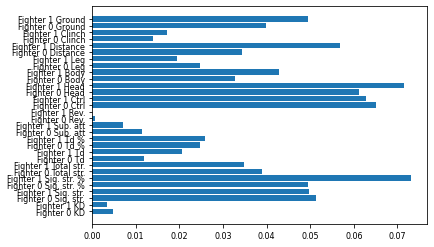

In [ ]:
# Visualize importances
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, clf.feature_importances_)

In [ ]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

accuracy_train = 1.0
accuracy_valid = 0.875


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# SVM
from sklearn.svm import SVC

clf = SVC(random_state=1).fit(X_train, y_train)
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

accuracy_train = 1.0
accuracy_valid = 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


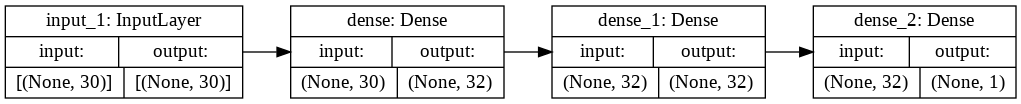

In [ ]:
# FFN
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=X_train.shape[1:]))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,081
Trainable params: 2,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 3.8512 - accuracy: 0.3571 - val_loss: 6.7302 - val_accuracy: 0.3750
Epoch 2/100
1/1 [==============================] - 0s 53ms/step - loss: 2.6542 - accuracy: 0.3929 - val_loss: 5.2319 - val_accuracy: 0.3750
Epoch 3/100
1/1 [==============================] - 0s 51ms/step - loss: 1.9792 - accuracy: 0.6071 - val_loss: 3.9652 - val_accuracy: 0.3750
Epoch 4/100
1/1 [==============================] - 0s 50ms/step - loss: 1.7427 - accuracy: 0.6429 - val_loss: 2.8005 - val_accuracy: 0.4375
Epoch 5/100
1/1 [==============================] - 0s 53ms/step - loss: 1.5592 - accuracy: 0.7143 - val_loss: 1.9001 - val_accuracy: 0.5000
Epoch 6/100
1/1 [==============================] - 0s 67ms/step - loss: 1.3372 - accuracy: 0.7143 - val_loss: 1.3348 - val_accuracy: 0.5625
Epoch 7/100
1/1 [==============================] - 0s 57ms/step - loss: 1.1509 - accuracy: 0.7500 - val_loss: 1.0749 - val_accuracy: 0.6250
Epoch 8/100
1/1 [=====

In [ ]:
model.evaluate(X_train, y_train)
model.evaluate(X_valid, y_valid)

1/1 [==============================] - 0s 19ms/step - loss: 0.3913 - accuracy: 0.8750


[0.39128726720809937, 0.875]

In [ ]:
idx = 6

In [ ]:
X_test.iloc[idx]

Fighter 0 KD               0.0
Fighter 1 KD               0.0
Fighter 0 Sig. str.       27.0
Fighter 1 Sig. str.       71.0
Fighter 0 Sig. str. %     39.0
Fighter 1 Sig. str. %     47.0
Fighter 0 Total str.      32.0
Fighter 1 Total str.     131.0
Fighter 0 Td               2.0
Fighter 1 Td               3.0
Fighter 0 Td %            50.0
Fighter 1 Td %            75.0
Fighter 0 Sub. att         1.0
Fighter 1 Sub. att         0.0
Fighter 0 Rev.             1.0
Fighter 1 Rev.             1.0
Fighter 0 Ctrl           209.0
Fighter 1 Ctrl           280.0
Fighter 0 Head            16.0
Fighter 1 Head            54.0
Fighter 0 Body            10.0
Fighter 1 Body            14.0
Fighter 0 Leg              1.0
Fighter 1 Leg              3.0
Fighter 0 Distance        26.0
Fighter 1 Distance        48.0
Fighter 0 Clinch           1.0
Fighter 1 Clinch           4.0
Fighter 0 Ground           0.0
Fighter 1 Ground          19.0
Name: 26, dtype: float64

In [ ]:
# 0 means fighter 0 won. 1 means fighter 1 won.
y_test.iloc[idx]

Winner    1
Name: 26, dtype: int64

In [ ]:
X_test.shape

(22, 30)

In [ ]:
X_test.iloc[idx].shape

(30,)

In [ ]:
model.predict(np.expand_dims(X_test.iloc[idx], 0))

array([[1.]], dtype=float32)